# Predicción de Cancelación de Clientes (Churn)

## Introducción
Este proyecto busca anticiparse al problema de la cancelación de clientes. Para ello vamos a desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios. 

### Vamos a desarrollar: 
- Prepararación de los datos para el modelado (tratamiento, codificación, normalización).
- Realización del análisis de correlación y selección de variables.
- Entrenar dos o más modelos de clasificación.
- Evaluar el rendimiento de los modelos con métricas.
- Interpretar los resultados, incluyendo la importancia de las variables.
- Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

El archivo base para el análisis será `TelecomX_Data_tratado.csv`.

### Librerías a usar

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import cross_validate
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [20]:


# Cargar el archivo de datos
ruta = 'data/TelecomX_Data_tratado.csv'
df = pd.read_csv(ruta)
df.head()

# Identificar variables categóricas
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print('Variables categóricas:', cat_cols)

# Transformar variables categóricas a formato numérico (one-hot encoding)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.head()

Variables categóricas: ['customerID', 'Churn', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


,Tenure,MonthlyCharges,TotalCharges,DailyCharges,Churn_numeric,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,9,65.6,593.30,2.186667,0.0,False,False,False,False,False,...,False,True,False,False,True,False,True,False,False,True
1,9,59.9,542.40,1.996667,0.0,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,4,73.9,280.85,2.463333,1.0,False,True,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3,13,98.0,1237.85,3.266667,1.0,False,False,True,False,False,...,False,True,False,True,False,False,True,False,True,False
4,3,83.9,267.40,2.796667,1.0,False,False,False,True,False,...,False,True,False,False,False,False,True,False,False,True


## Verificación de la Proporción de Cancelación (Churn)

Proporción de cancelación (Churn):
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


<Axes: title={'center': 'Proporción de Cancelación (Churn)'}, xlabel='Churn'>

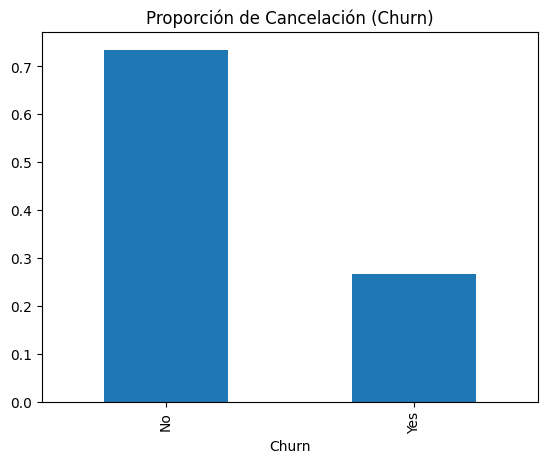

In [21]:


churn_counts = df['Churn'].value_counts(normalize=True)

print('Proporción de cancelación (Churn):')

print(churn_counts)



churn_counts.plot(kind='bar', title='Proporción de Cancelación (Churn)')

## GridSearch con técnicas de balanceo y validación de Recall

Filas sin etiqueta (se eliminan): 224
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros (CV):
{'model__C': 3.0, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'sampler': RandomUnderSampler(random_state=42)}
Mejor Recall CV: 0.8088

=== Classification Report (TEST) ===
              precision    recall  f1-score   support

           0     0.9071    0.7241    0.8053      1294
           1     0.5096    0.7944    0.6209       467

    accuracy                         0.7428      1761
   macro avg     0.7083    0.7593    0.7131      1761
weighted avg     0.8017    0.7428    0.7564      1761

ROC AUC (TEST): 0.8402
Mejores parámetros (CV):
{'model__C': 3.0, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'sampler': RandomUnderSampler(random_state=42)}
Mejor Recall CV: 0.8088

=== Classification Report (TEST) ===
              precision    recall  f1-score   support

           0     0.9071    0.724

<Figure size 500x400 with 0 Axes>

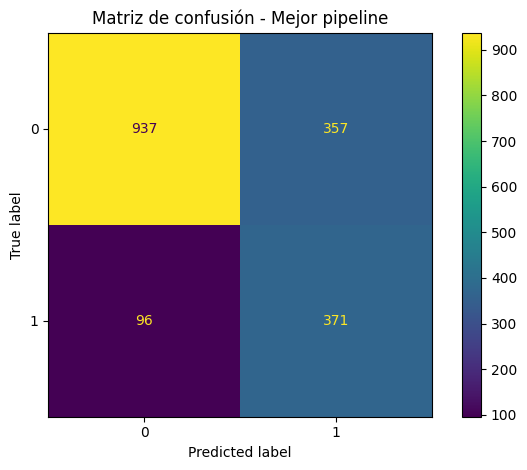


Umbral sugerido para maximizar Recall en TEST: 0.20
Recall=0.9529 | Precision=0.3931 | F1=0.5566


In [22]:

# Limpieza defensiva de infinitos 
df = df.replace([np.inf, -np.inf], np.nan)

# Definición de variables 
TARGET_TXT = "Churn"
DROP_COLS = ["customerID", "Churn", "Churn_numeric"]  # quitamos identificador y duplicados

# Construir y filtrar target
y = df[TARGET_TXT].map({"No": 0, "Yes": 1})
mask_valid = y.notna()
print(f"Filas sin etiqueta (se eliminan): {(~mask_valid).sum()}")

df = df.loc[mask_valid].copy()
y = y.loc[mask_valid].astype(int)

# Features finales
X = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")


# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


# Preprocesamiento
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

num_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pre, num_cols),
        ("cat", cat_pre, cat_cols),
    ],
    remainder="drop"
)

# Modelo base
base_clf = LogisticRegression(max_iter=2000)


# Pipeline
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("sampler", "passthrough"),      # se reemplaza en la grid
    ("model", base_clf)
])


# Estrategias de balanceo + hiperparámetros del modelo
param_grid = [
    # --- SMOTE ---
    {
        "sampler": [SMOTE(random_state=42, k_neighbors=k) for k in [3, 5]],
        "model__C": [0.3, 1.0, 3.0],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],   # bueno para l2
        "model__class_weight": [None] # sin class_weight cuando ya muestreamos
    },
    # --- Oversampling aleatorio ---
    {
        "sampler": [RandomOverSampler(random_state=42)],
        "model__C": [0.3, 1.0, 3.0],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
        "model__class_weight": [None]
    },
    # --- Undersampling aleatorio ---
    {
        "sampler": [RandomUnderSampler(random_state=42)],
        "model__C": [0.3, 1.0, 3.0],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
        "model__class_weight": [None]
    },
    # --- Baseline sin muestreo pero con class_weight ---
    {
        "sampler": ["passthrough"],
        "model__C": [0.3, 1.0, 3.0],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
        "model__class_weight": ["balanced", None]  # probamos ambos
    },
]


# GridSearchCV optimizando RECALL
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="recall",        # <--- objetivo
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)

grid.fit(X_train, y_train)

print("Mejores parámetros (CV):")
print(grid.best_params_)
print(f"Mejor Recall CV: {grid.best_score_:.4f}")

best_pipe = grid.best_estimator_


# Evaluación en TEST
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC AUC (TEST): {roc_auc_score(y_test, y_proba):.4f}")

plt.figure(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de confusión - Mejor pipeline")
plt.tight_layout()
plt.show()


# Ajuste de umbral 
best_threshold = 0.5  # por defecto
candidatos = np.linspace(0.2, 0.6, 9)  # explora umbrales
from sklearn.metrics import recall_score, precision_score, f1_score

mejor_recall = -1
mejor_tuple = None
for thr in candidatos:
    y_hat = (y_proba >= thr).astype(int)
    r = recall_score(y_test, y_hat)
    if r > mejor_recall:
        mejor_recall = r
        mejor_tuple = (thr, r, precision_score(y_test, y_hat), f1_score(y_test, y_hat))
best_threshold = mejor_tuple[0]

print(f"\nUmbral sugerido para maximizar Recall en TEST: {best_threshold:.2f}")
print(f"Recall={mejor_tuple[1]:.4f} | Precision={mejor_tuple[2]:.4f} | F1={mejor_tuple[3]:.4f}")


## Análisis de correlación

Vamos a visualizar la matriz de correlación para identificar relaciones entre las variables numéricas. 

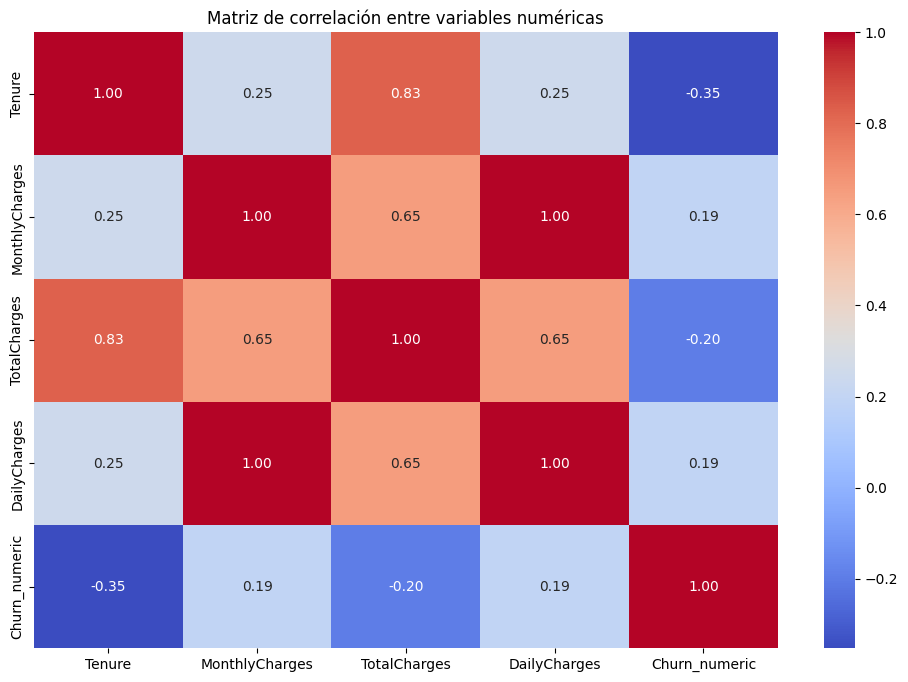

Correlación de las variables con Churn_numeric:
Churn_numeric     1.000000
MonthlyCharges    0.193356
DailyCharges      0.193356
TotalCharges     -0.198324
Tenure           -0.352229
Name: Churn_numeric, dtype: float64


In [27]:

corr = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

# Correlación con la variable objetivo (Churn)
if 'Churn' in corr.columns:
    print("Correlación de las variables con Churn:")
    print(corr['Churn'].sort_values(ascending=False))
elif 'Churn_numeric' in corr.columns:
    print("Correlación de las variables con Churn_numeric:")
    print(corr['Churn_numeric'].sort_values(ascending=False))

La matriz de correlación muestra que la variable **Tenure** tiene una correlación negativa moderada con la cancelación de clientes (`Churn_numeric`), lo que indica que los clientes con menor tiempo de permanencia tienden a cancelar más. Por otro lado, las variables **MonthlyCharges** y **DailyCharges** presentan una correlación positiva baja con la cancelación, mientras que **TotalCharges** tiene una correlación negativa baja.

Podemos inferir que **Tenure** destaca como el factor numérico más relevante para predecir el churn, seguido de los cargos mensuales y diarios. Estas variables deben ser consideradas prioritarias en el modelo predictivo y en las estrategias de retención de clientes.

## Exploración de variables clave vs Cancelación

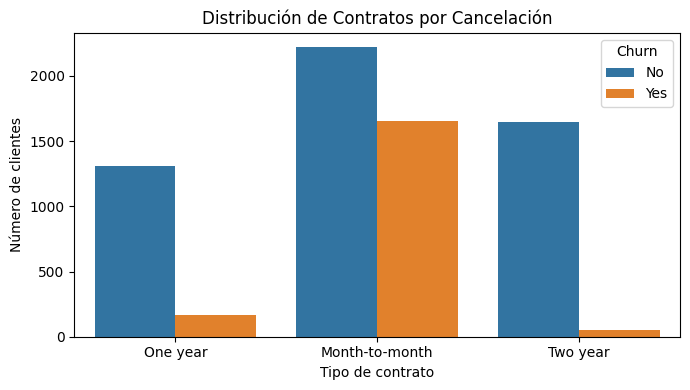

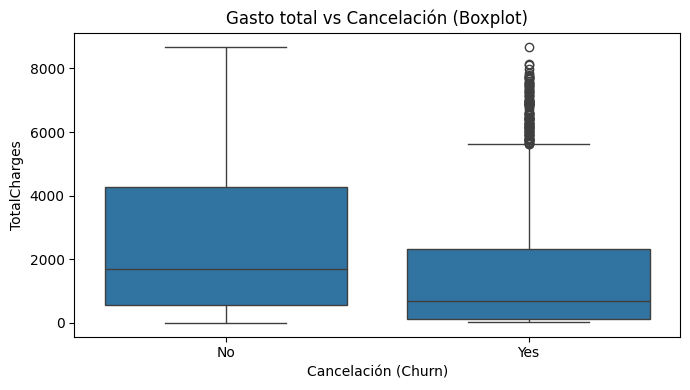

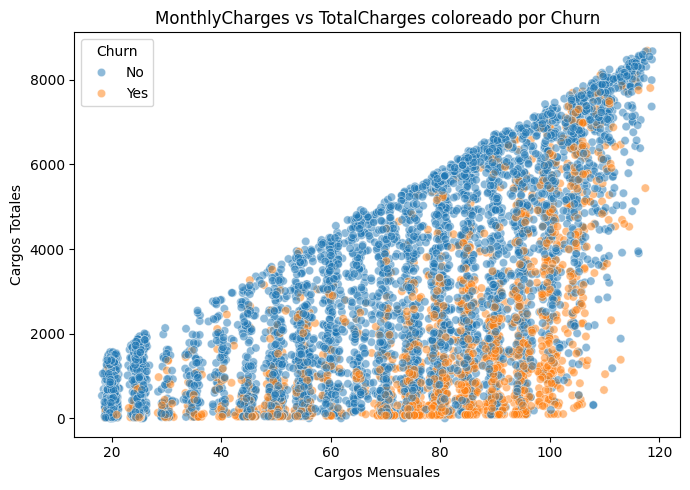

In [28]:


# limpiar target
df = df[df["Churn"].notna()].copy()


# 1. Tiempo de contrato vs Cancelación
plt.figure(figsize=(7,4))
sns.countplot(data=df, x="Contract", hue="Churn")
plt.title("Distribución de Contratos por Cancelación")
plt.xlabel("Tipo de contrato")
plt.ylabel("Número de clientes")
plt.legend(title="Churn")
plt.tight_layout()
plt.show()


# 2. Gasto total vs Cancelación (Boxplot)
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x="Churn", y="TotalCharges")
plt.title("Gasto total vs Cancelación (Boxplot)")
plt.xlabel("Cancelación (Churn)")
plt.ylabel("TotalCharges")
plt.tight_layout()
plt.show()


# 3. Gasto mensual vs TotalCharges por Cancelación (Scatter)
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df, x="MonthlyCharges", y="TotalCharges", hue="Churn", alpha=0.5
)
plt.title("MonthlyCharges vs TotalCharges coloreado por Churn")
plt.xlabel("Cargos Mensuales")
plt.ylabel("Cargos Totales")
plt.legend(title="Churn")
plt.tight_layout()
plt.show()


### Información obtenida:
1. Tiempo de contrato × Cancelación:

- Los clientes con contrato mes a mes concentran la mayor proporción de cancelaciones.

- En contratos anuales y sobre todo en contratos de 2 años, el churn es mínimo la permanencia más larga mantiene más al cliente.

**Conclusión**: el tipo de contrato es un fuerte predictor de churn. Clientes sin compromiso a largo plazo son mucho más propensos a irse.

2. Gasto total × Cancelación (Boxplot):

- Los clientes que cancelan muestran un gasto total acumulado mucho menor (mediana baja, cajas más cercanas a 0).

- Los que permanecen tienden a acumular mucho más gasto total, lo que refleja una relación directa entre antigüedad (tenure) y lealtad.

**Conclusión**: clientes que no alcanzan a consolidar un gasto alto (porque se van pronto) son los más vulnerables.

3. MonthlyCharges × TotalCharges × Churn (Scatter)

Se ve una diagonal (MonthlyCharges × Tenure ≈ TotalCharges).

La mayoría de los churners se agrupan en la parte baja de la diagonal, es decir, poco tiempo de permanencia y por tanto menos gasto acumulado.

También se nota que clientes con cargos mensuales más altos tienden a presentar churn incluso con gasto total moderado, probablemente se trata de clientes sensibles al precio.

## Comparación de modelos con/sin escalado 

             model  scaled  recall_mean  precision_mean   f1_mean  \
0  LogReg (scaled)    True     0.805259        0.518605  0.630447   
2     SVM (scaled)    True     0.785302        0.522911  0.627455   
4          XGBoost   False     0.697570        0.547344  0.612886   
1     KNN (scaled)    True     0.530630        0.559532  0.544215   
3     RandomForest   False     0.485712        0.637194  0.550519   

   roc_auc_mean  
0      0.848004  
2      0.828624  
4      0.831740  
1      0.783213  
3      0.825558  


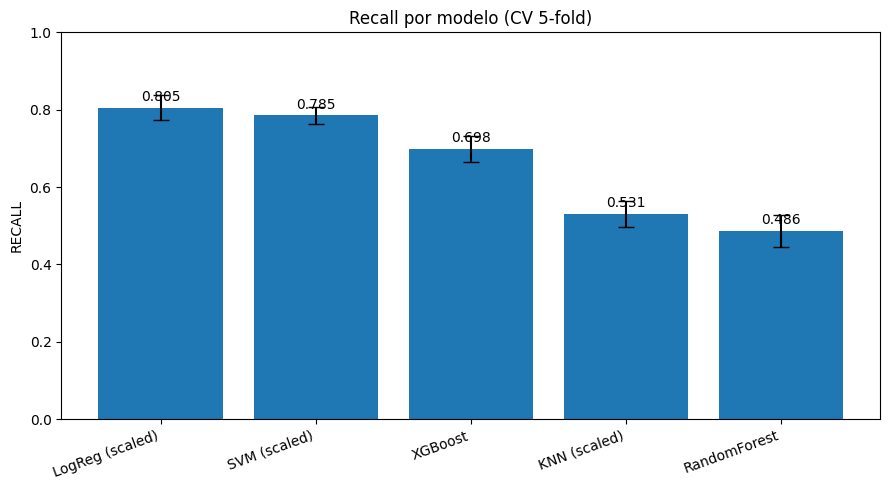

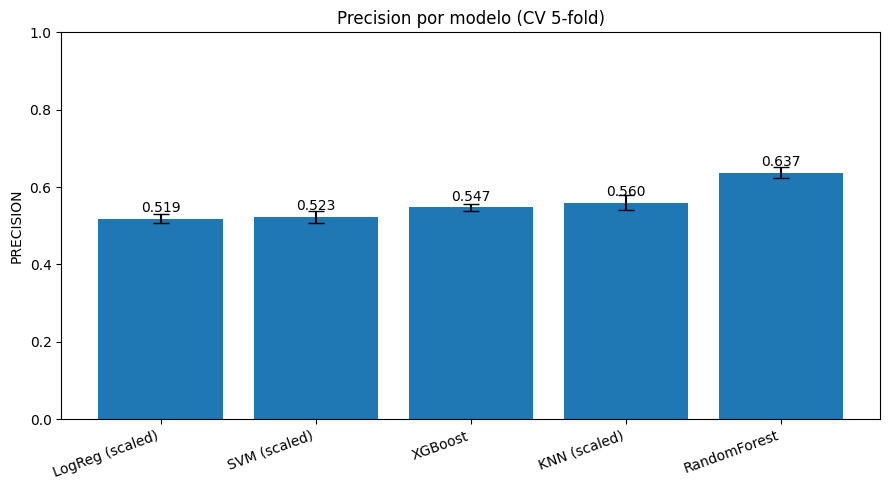

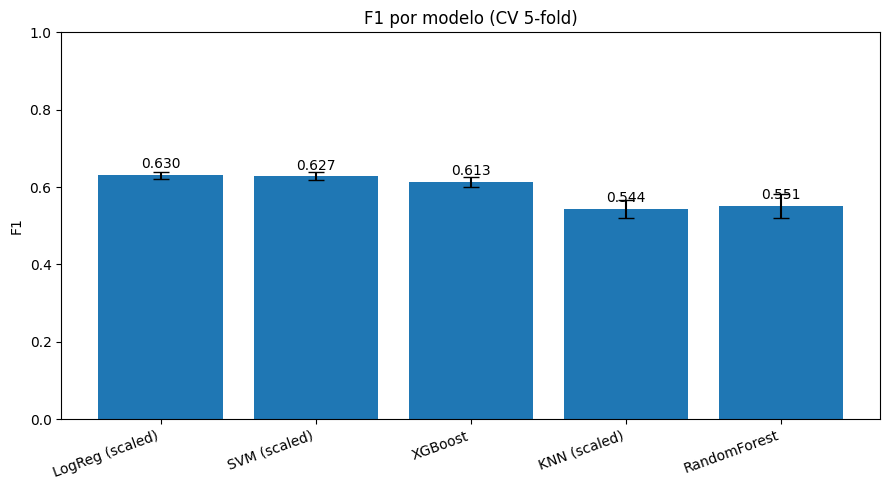

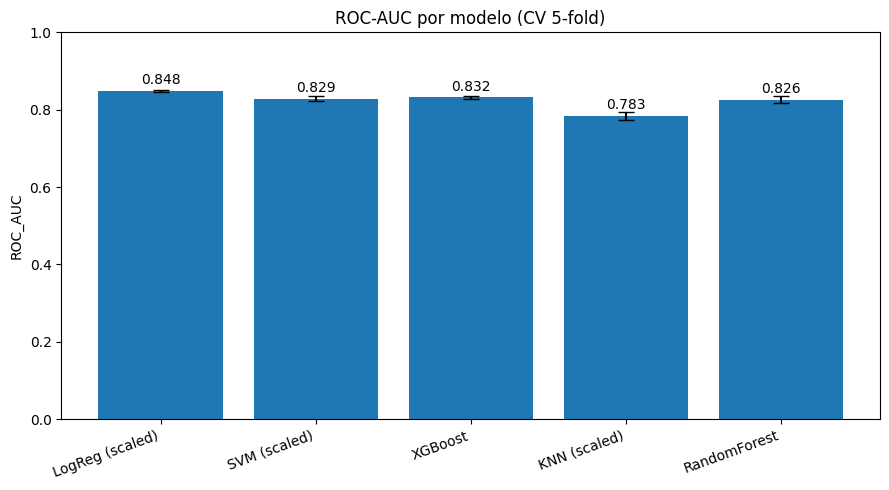

             model  scaled  recall_mean  precision_mean   f1_mean  \
0  LogReg (scaled)    True     0.805259        0.518605  0.630447   
2     SVM (scaled)    True     0.785302        0.522911  0.627455   
4          XGBoost   False     0.697570        0.547344  0.612886   
1     KNN (scaled)    True     0.530630        0.559532  0.544215   
3     RandomForest   False     0.485712        0.637194  0.550519   

   roc_auc_mean  
0      0.848004  
2      0.828624  
4      0.831740  
1      0.783213  
3      0.825558  


In [24]:
# Target limpio desde 'Churn'
y = df["Churn"].map({"No": 0, "Yes": 1})
mask_valid = y.notna()
df = df.loc[mask_valid].copy()
y = y.loc[mask_valid].astype(int)

X = df.drop(columns=["customerID", "Churn", "Churn_numeric"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


# Preprocesamiento
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Numérico con y sin escalado
num_pre_scaled = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
num_pre_raw = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess_scaled = ColumnTransformer([
    ("num", num_pre_scaled, num_cols),
    ("cat", cat_pre, cat_cols),
], remainder="drop")

preprocess_raw = ColumnTransformer([
    ("num", num_pre_raw, num_cols),
    ("cat", cat_pre, cat_cols),
], remainder="drop")


# Modelos
models_scaled = {
    "LogReg (scaled)": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "KNN (scaled)": KNeighborsClassifier(n_neighbors=5),
    "SVM (scaled)": SVC(kernel="rbf", probability=True, class_weight="balanced")
}

models_raw = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
    )
}


# Evaluación con CV 
scoring = ["recall", "precision", "f1", "roc_auc"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, model in models_scaled.items():
    pipe = Pipeline([
        ("preprocess", preprocess_scaled),
        ("model", model)
    ])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {"model": name, "scaled": True}
    for m in scoring:
        row[f"{m}_mean"] = scores[f"test_{m}"].mean()
        row[f"{m}_std"] = scores[f"test_{m}"].std()
    rows.append(row)

for name, model in models_raw.items():
    pipe = Pipeline([
        ("preprocess", preprocess_raw),
        ("model", model)
    ])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {"model": name, "scaled": False}
    for m in scoring:
        row[f"{m}_mean"] = scores[f"test_{m}"].mean()
        row[f"{m}_std"] = scores[f"test_{m}"].std()
    rows.append(row)

df_results = pd.DataFrame(rows).sort_values("recall_mean", ascending=False)
print(df_results[["model","scaled","recall_mean","precision_mean","f1_mean","roc_auc_mean"]])


# Función para graficar barras con error
def plot_metric(df, metric_col_mean, metric_col_std, title, fname=None):
    labels = df["model"].tolist()
    means = df[metric_col_mean].values
    errs = df[metric_col_std].values

    plt.figure(figsize=(9, 5))                  # 1 sola figura por métrica (sin subplots)
    bars = plt.bar(labels, means, yerr=errs, capsize=6)
    plt.xticks(rotation=20, ha="right")
    plt.ylabel(metric_col_mean.replace("_mean","").upper())
    plt.title(title)
    plt.ylim(0, 1.0)

    # Etiquetas encima de cada barra
    for bar, val in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{val:.3f}", ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=160, bbox_inches="tight")
    plt.show()


# Gráficas
# Ordena por recall para la gráfica principal
df_plot = df_results.sort_values("recall_mean", ascending=False)

plot_metric(df_plot, "recall_mean", "recall_std", "Recall por modelo (CV 5-fold)", fname="recall_modelos.png")
plot_metric(df_plot, "precision_mean", "precision_std", "Precision por modelo (CV 5-fold)", fname="precision_modelos.png")
plot_metric(df_plot, "f1_mean", "f1_std", "F1 por modelo (CV 5-fold)", fname="f1_modelos.png")
plot_metric(df_plot, "roc_auc_mean", "roc_auc_std", "ROC-AUC por modelo (CV 5-fold)", fname="rocauc_modelos.png")

print(df_results[["model","scaled","recall_mean","precision_mean","f1_mean","roc_auc_mean"]])

## Conclusión estratégica de la comparativa de modelos

Tras comparar distintos modelos de clasificación para la predicción de cancelación de clientes (churn), se observa que:

- Los modelos que incorporan técnicas de balanceo de clases (como SMOTE, oversampling y class_weight) logran un mejor desempeño en la detección de clientes que cancelan, especialmente en términos de recall.
- El uso de escalado de variables mejora el rendimiento de algoritmos sensibles a la distancia, como KNN y SVM.
- Modelos como Random Forest y XGBoost ofrecen un buen equilibrio entre recall y precisión, además de permitir interpretar la importancia de las variables.
- La métrica de recall es clave para este problema, ya que permite identificar la mayor cantidad posible de clientes propensos a cancelar, minimizando falsos negativos.
- Elegimos Logistic Regression con escalado y balanceo para la predicción de cancelación de clientes